# Generate data for sparse coding with autoencoder

We select a few continuous measures, like heart rate, sBP, dBP, SpO2, and RR

Created: 2019-01-03

# Methods

In [403]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [404]:
def _total_minutes(td):
    return td.total_seconds() / 60
def total_minutes(td):
    return td.apply(_total_minutes)
def _total_hours(td):
    return td.total_seconds() / 60 / 60
def total_hours(td):
    return td.apply(_total_hours)
def _total_days(td):
    return td.total_seconds() / 60 / 60 / 24
def total_days(td):
    return td.apply(_total_days)

def from_julian_time(z):
    return pd.to_datetime(z - pd.Timestamp(0).to_julian_date(), unit='D')

In [405]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 72

# green, red, blue, yellow, purple, blue, grey
flatui = ["#2DEC2A","#F6204F","#33CCFF","#FFCC33","#9b59b6","#25BCFE","#95a5a6"]
default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF","#F9AE23"]

def fontsize(ax, fz = 14):
    """Set all fontsizes to fz"""
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fz)

def labels(ax, title=None, subtitle=None, xlabel=None, ylabel=None, xticklabels = None, legend_title = None, legend_labels=None, legend_loc = 'upper right', fz=14, grid=True):
    """Assign titles and labels.
    xticklabels and legend_labels should be lists, all others are strings."""
    if title is not None:
        if subtitle is None:
            plt.title(title)
        else:
            plt.suptitle(title, y=1, fontsize=fz+2)
            plt.title(subtitle)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if legend_title is not None and legend_labels is not None:
        handles, ax_legend_labs = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel);
    if ylabel is not None:
        plt.ylabel(ylabel);
    if grid:
        plt.grid(linestyle='dotted')
    fontsize(ax, fz)

def annotate(ax, x, y, text, offset=5):
    """Place text in different locations of the plot.
    x and y are lists of locations on the plot. text can be a list of numbers or strings."""
    for i in range(len(x)):
        ax.text(x[i], y[i]+offset, text[i], bbox={'facecolor':'white','pad':5}, horizontalalignment='center')

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [406]:
from scipy import stats
EPS = 1e-12
def robust_transform(x, rescale=True):
    h = 1/(1 + np.exp( - (x-np.nanmedian(x)) / (1.35 * stats.iqr(x[np.isfinite(x)]) + EPS) ))
    if rescale:
        h = (h - np.nanmin(h)) / (np.nanmax(h) - np.nanmin(h))
    return h

# Load data

In [407]:
PATH = '/local/home/Asif/data/ards/'
files = [f for f in os.listdir(PATH) if f.endswith('.csv')]
print(len(files))

71972


In [408]:
parameters = ['FiO2', 'PaO2', 'PaCO2', 'pH', 'HR', 'RespRate', 'SpO2', 'NISysABP', 'NIDiaABP', 'NIMeanABP', 'Glucose', 'Temp', 'PEEP', 'BUN', 'Calcium', 'Creatinine', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Potassium', 'Sodium', 'WBC', 'Albumin', 'Bilirubin', 'ALT', 'AST', 'ALP', 'Lactate', 'INR', 'TotalCO2', 'ISysABP', 'IDiaABP', 'IMeanABP', 'PTT', 'Bands', 'TVInsp', 'SaO2', 'PAPMean', 'PAPDia', 'PAPSys', 'PPlat', 'MAWP']

def load_file(f):
    df = pd.read_csv(PATH + f)
    pid = df.loc[df.Parameter == 'patientUnitStayID'].iloc[0].Value
    label_28day_mortality = float(df[df.Parameter == 'label_28day_mortality'].iloc[0].Value)
    timeOfID = float(df.loc[df.Parameter == 'timeOfID','Value'].iloc[0])
    df = df.loc[(df.Time>=timeOfID) & (df.Time<=(timeOfID+24*60)) & (df.Parameter.isin(parameters))].sort_values('Time').reset_index(drop=True).copy()
    df.loc[:,'Value'] = df.loc[:,'Value'].astype(float)
    df.loc[:,'Time'] = df.loc[:,'Time'] - timeOfID # time in minutes from ID
    df = df.assign(TimeStamp=[pd.Timestamp('2018-01-01') + pd.Timedelta(f'{t}m') for t in df.Time])
    return df, (pid, label_28day_mortality, timeOfID)

In [409]:
def rbfinterp(alpha, t, x, r):
    L = len(t)
    w = np.exp(-alpha * np.sqrt(np.square(np.tile(r,[len(t),1]) - t[:,np.newaxis])))
    xh = (w * x[:,np.newaxis]).sum(0) / w.sum(0)
    return xh, w

In [417]:
from sklearn.metrics import pairwise_distances
def squared_exponential(distance, alpha=1):
    return np.exp((distance*alpha)**2 / -2)

def kinterp(alpha, t, x, r):
    L = len(t)
    Krt = squared_exponential(pairwise_distances(r[:,np.newaxis],t[:,np.newaxis]))

alpha 30


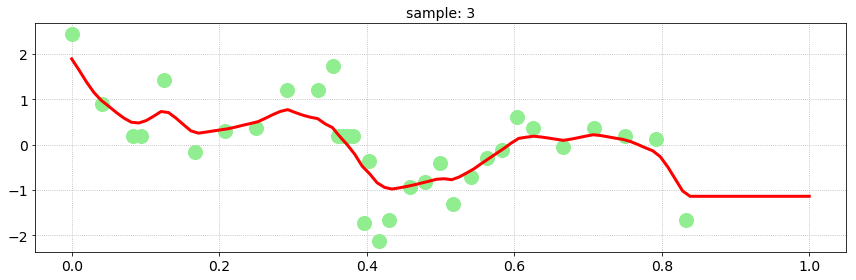

In [507]:
min_num_samples = 1
timesteps = 48

i = 3

df, meta = load_file(files[i])
dx = df[df.Parameter == 'NISysABP']
if len(dx) > min_num_samples:
    x = dx.set_index('TimeStamp')
    x = x.Value.round(2)
    xz = (x - np.nanmean(x)) / np.nanstd(x) # zscore
    #xz = robust_transform(x)
    t = total_minutes(pd.Series(xz.index - xz.index[0])).values
    t = t/1440
    x = xz.values
else:
    print('Not enough samples')

if len(x) > 20:
    alpha = 30
elif (len(x) > 10) & (len(x) < 20):
    alpha = 15
else:
    alpha = 5
# alpha = 20
print('alpha',alpha)
r = np.linspace(0,1,100)
xh, w = rbfinterp(alpha,t,x,r)

t = t[:,np.newaxis]
r = r[:,np.newaxis]

from scipy.interpolate import Rbf
rbf = Rbf(t, x, function='gaussian')
fi = rbf(r)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.plot(t, x,'o',color='lightgreen',ms=14, label='measured')
plt.plot(r, xh,'-',color='red',lw=3)
# plt.plot(r, fi,'-',color=default_colors[0],lw=3)
labels(ax, title=f'sample: {i}')
plt.tight_layout()

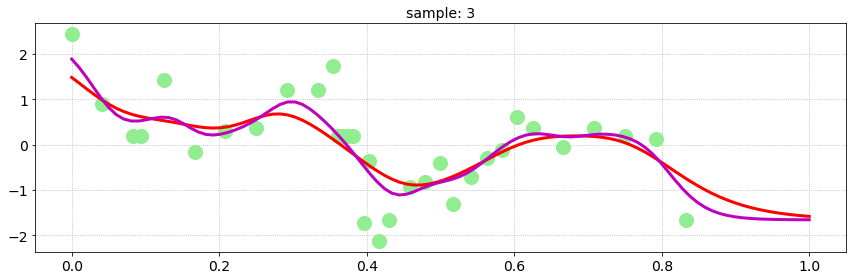

In [553]:
alpha = 30

Krt = squared_exponential(pairwise_distances(r,t), alpha)
# Ktr = Krt.T
# Ktt = squared_exponential(pairwise_distances(t,t), alpha)
# Ktt_inv = np.linalg.inv(Ktt)
# xhat = Krt.dot(Ktt_inv).dot(x)

xhat = np.dot(Krt,x) / Krt.sum(1)

xh = (Ktr * x[:,np.newaxis]).sum(0) / Ktr.sum(0)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.plot(t, x,'o',color='lightgreen',ms=14, label='measured')
plt.plot(r, xh,'-',color='red',lw=3)
plt.plot(r, xhat,'-',color='m',lw=3)
labels(ax, title=f'sample: {i}')
plt.tight_layout()

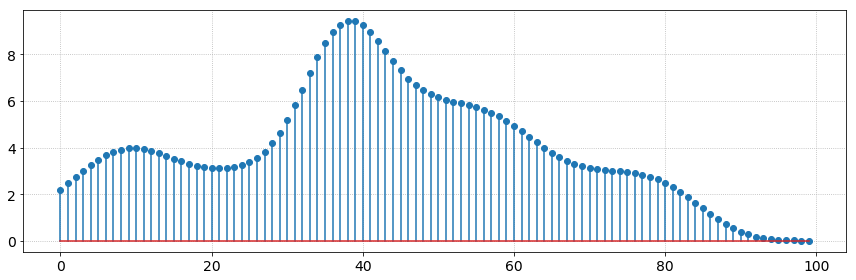

In [545]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.stem(Krt.sum(1))
labels(ax)
plt.tight_layout()

In [412]:
def gendata(f):
    df, meta = load_file(f)
    dx = df[df.Parameter == 'NISysABP']
    if len(dx) > min_num_samples:
        x = dx.set_index('TimeStamp')
        x = x.Value.round(2)
        t = total_minutes(pd.Series(x.index - x.index[0])).values
        t = t/1440
        x = x.values
        # apply different bandwidth based on number of samples
        if len(x) > 20:
            alpha = 40
        elif (len(x) > 10) & (len(x) < 20):
            alpha = 15
        else:
            alpha = 5
        r = np.linspace(0,1,100)
        xh, w = rbfinterp(alpha,t,x,r)
        return xh, meta[0]
    else:
        return None

In [326]:
import multiprocessing
from tqdm import tqdm

data = {}

pool = multiprocessing.Pool(processes=12)
with tqdm(total=len(files)) as progress_bar:
    for out in pool.imap_unordered(gendata, files):
        if out is not None:
            if np.isnan(out[0]).sum() == 0:
                data[out[1]] = out[0]
        progress_bar.update(1)

100%|██████████| 71972/71972 [04:29<00:00, 267.30it/s]


In [327]:
pool.close()

In [328]:
!free -hm

              total        used        free      shared  buff/cache   available
Mem:           251G        4.7G        236G         58M         10G        246G
Swap:           31G          0B         31G


In [329]:
pids = list(data.keys())

In [330]:
X = np.array(list(data.values()))

In [331]:
X.shape

(45864, 100)

In [332]:
np.save('/local/home/Asif/data/tmp/ards_NISysABP.npy',X.astype('f'))

In [333]:
np.save('/local/home/Asif/data/tmp/ards_NISysABP_patientUnitStayIDs.npy',np.array(pids).astype('f'))